In [1]:
import sys
import importlib

sys.path.append("../")

from src import utils
from src.utils import *


from src import plot_utils
from src import graph_utils
from src import inpaint_utils
from src import fiberatlas_utils

## Goal

The goal of this notebook is to do create paths (voxel level) to match pairs of regions with highest connectivity paths

## Description
Generate paths according to the functional connectivity of pairs of regions. 
- E.g using highest sum of energy (energy being positive correlation)

Generate usual bundle paths prior to optimization and prepare functional connectivity information.

In [15]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))
nsubject = hf.get('header').get('nsubjects')[()]
dim = hf.get('header').get('dim')[()]
fiber_affine = hf.get('header').get('affine')[()]

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]

gm_mask_subj = nib.load('../../atlas_data/moviedata_fMRI_eg/gm_mask_subj7.nii').get_fdata() 
wm_mask_subj = (gm_mask_subj + 1) % 2


consistency_view = fiberatlas_utils.get_aggprop(hf, 'consistency')
length_view = fiberatlas_utils.get_aggprop(hf, 'length')
nbStlines_view = fiberatlas_utils.get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

# NOTE: consider bundles that appear at least in 30 % of the subjects
thresh_subjapp = int(np.ceil(nsubject * 0.1)) 

fmri_coords = load(f'../resources/scale{scale}_fmri2atlas_coords_div{int(np.ceil(thresh_subjapp))}.pkl')

voxel_fmri = nib.load('../../atlas_data/moviedata_fMRI_eg/movie_group_fmri.nii')
rest_affine = voxel_fmri.affine
vdim = voxel_fmri.shape[:3]

### No fibers Remove

In [16]:
X = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.array(X)

root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                             nib.load(root + atlas_of_interest).affine)

Xp = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundle_coords = tmp[:,[0,1,2]]

        prob_vox = np.zeros_like(prob_regions[:,:,:,0])
        prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

        region_i = prob_regions[:,:,:,i-1]
        region_j = prob_regions[:,:,:,j-1]

        bundle_proba_i = (region_i * prob_vox)
        bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
        bundle_proba_j = (region_j * prob_vox)
        bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = bproba_i
        vec[j-1] = bproba_j
        Xp.append(vec)

Xp = np.array(Xp)
Xp = np.nan_to_num(Xp)

region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")
regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]

# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt = graph_utils.compute_directed_laplacian(cycle)

Xmult = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)

save(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_stability-noremove.pkl", bundle_opt)

  0%|          | 0/95 [00:00<?, ?it/s]

 36%|███▌      | 34/95 [31:50<02:37,  2.58s/it]   /var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_4187/3114914079.py:39: RuntimeWarning: Mean of empty slice.
  bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 200/200 [05:47<00:00,  1.74s/it]

Losses are decomposed into:
generic loss=tensor([1.8748])
spatialloss=tensor([2965814.])
temporalloss=tensor([14861.0381])
sumloss=tensor([1.8748])


In [17]:
bundle_opt_norem = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_stability-noremove.pkl")

In [ ]:
wm_inpaint, wm_masked = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt_norem[0], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)

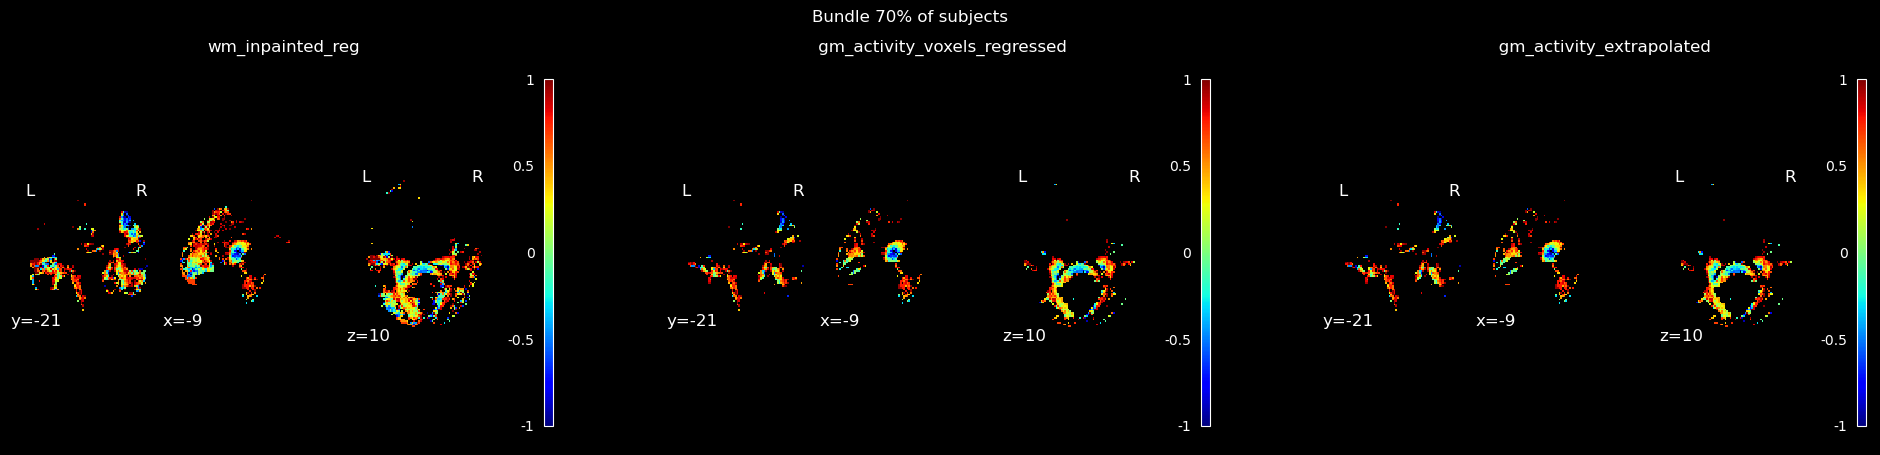

In [18]:
inpaint_mods = [wm_inpaint, wm_masked, wm_masked]
all_inpaints_names = f'wm_inpainted_reg, gm_activity_voxels_regressed,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)

### Random fibers Remove

In [4]:
perc = 10
np.random.seed(99)

edges = np.array(np.where(consistency_view > 0)).T
toremove = edges[np.random.choice(np.arange(len(edges)), len(edges)//perc, replace=False)]

In [7]:
# Example with 10% removed
X = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if np.min(np.linalg.norm(np.array([i-1,j-1]) - toremove, axis=1)) < 1e-8:
            # If belong to the removing edges set then skip and do not add un bundles_labels
            continue
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.array(X)

root = '../../atlas_data/fiber_atlas/yasser_datacomp/volspams_compress/'

atlas_of_interest = f'compresslausanne2018.scale{scale}.sym.corrected.ctx+subc.volspams.nii.gz'

prob_regions, prob_affine = (nib.load(root + atlas_of_interest).get_fdata()[:,:,:,1:], 
                             nib.load(root + atlas_of_interest).affine)

Xp = []
bundles_labels = []
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = fiberatlas_utils.get_bundles_betweenreg(hf, i, j, verbose=False)
        if np.min(np.linalg.norm(np.array([i-1,j-1]) - toremove, axis=1)) < 1e-8:
            continue
        if tmp is None: continue
        if np.sum(tmp[:,3] >= (thresh_subjapp)) == 0: continue
        bundle_coords = tmp[:,[0,1,2]]

        prob_vox = np.zeros_like(prob_regions[:,:,:,0])
        prob_vox[bundle_coords[:,0], bundle_coords[:,1], bundle_coords[:,2]] = 1.0

        region_i = prob_regions[:,:,:,i-1]
        region_j = prob_regions[:,:,:,j-1]

        bundle_proba_i = (region_i * prob_vox)
        bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
        bundle_proba_j = (region_j * prob_vox)
        bproba_j = bundle_proba_j[bundle_proba_j!=0].mean()

        bundles_labels.append((i,j))
        vec = np.zeros(nb_regions)
        vec[i-1] = bproba_i
        vec[j-1] = bproba_j
        Xp.append(vec)

Xp = np.array(Xp)
Xp = np.nan_to_num(Xp)

region_ftimecourse = load(f"../../atlas_data/moviedata_fMRI_eg/yasseratlased_fmri/ftimecourse_95_scale{scale}.pkl")
regions_in_voxels = load(f'../../atlas_data/fiber_atlas/regions95_voxels_scale{scale}.pkl')[:,:,:,1:]

# spatial graph defining
bundle_graph = np.zeros((X.shape[0], X.shape[0]))
for k in range(X.shape[0]):
    avect1 = X[k]
    for s in range(X.shape[0]):
        if s == k: continue
        avect2 = X[s]
        if np.abs(avect1 - avect2).sum() <= 2:
            bundle_graph[k,s] = 1.0
            bundle_graph[s,k] = 1.0

# temporal graph defining
cycle = graph_utils.make_cycle(region_ftimecourse.shape[-1])

Ls = graph_utils.compute_directed_laplacian(bundle_graph)
Lt = graph_utils.compute_directed_laplacian(cycle)

Xmult = np.array([Xp.T for _ in range(region_ftimecourse.shape[-1])])

bundle_opt, logs = inpaint_utils.optimize_lreg(Xmult, region_ftimecourse, Ls=Ls, Lt=Lt, 
                                               verbose=True, num_epochs=200, logging=True, p1=0, p2=0, lr=1)

save(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_stability-{perc}p_remove.pkl", bundle_opt)

 36%|███▌      | 34/95 [01:02<01:20,  1.31s/it]/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_4187/2224519814.py:45: RuntimeWarning: Mean of empty slice.
  bproba_i = bundle_proba_i[bundle_proba_i!=0].mean()
/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 200/200 [04:37<00:00,  1.39s/it]

Losses are decomposed into:
generic loss=tensor([0.5553])
spatialloss=tensor([2775056.])
temporalloss=tensor([15768.5576])
sumloss=tensor([0.5553])


In [19]:
bundle_opt_wrem = load(f"../resources/weights_regressors_activity/weighted_bundle_activity_timevertex{thresh_subjapp}_scale{scale}_stability-{perc}p_remove.pkl")

In [11]:
wm_inpaint, wm_masked = inpaint_utils.interpolate_activity(fmri_coords, bundles_labels, bundle_opt_wrem[0], vdim, 
                                                        wmmask=wm_mask_subj, normalizing=True, verbose=False)

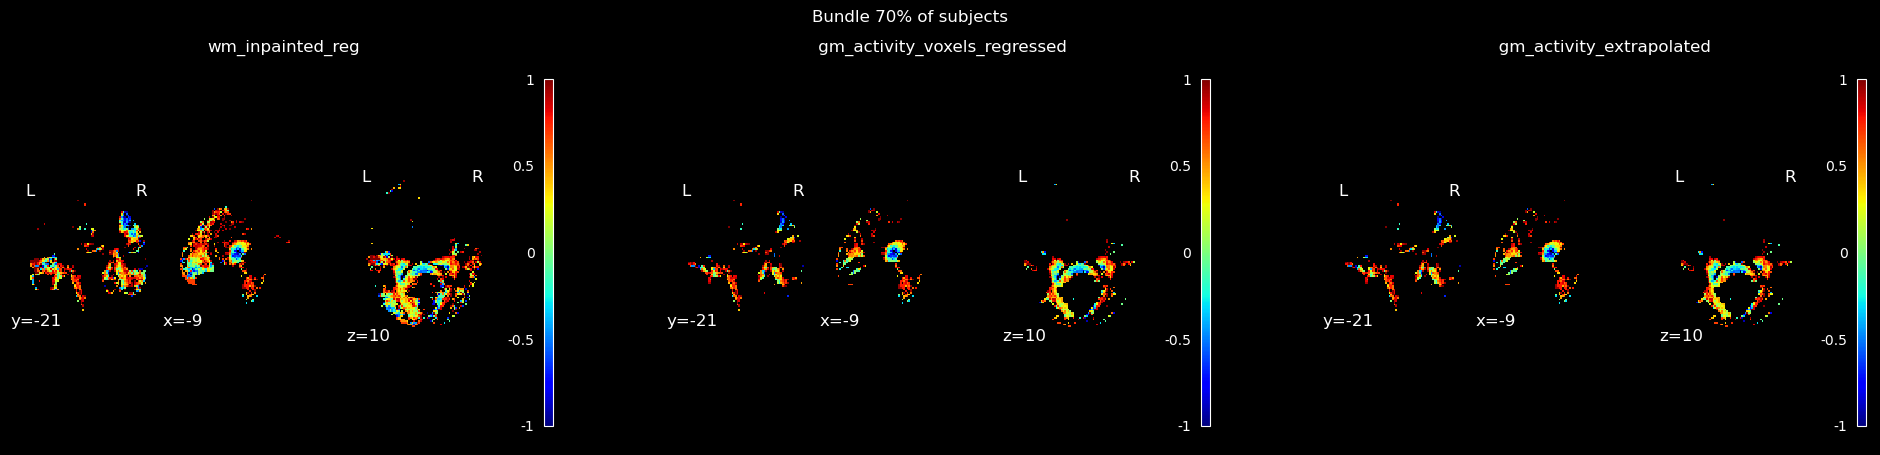

In [14]:
inpaint_mods = [wm_inpaint, wm_masked, wm_masked]
all_inpaints_names = f'wm_inpainted_reg, gm_activity_voxels_regressed,   gm_activity_extrapolated'.split(',')

affines = [rest_affine] * 3
coords_of_interest = [(-9,-21,10)] * 3
plot_utils.plot_compare_inpainting(inpaint_mods, coords_of_interest, affines, all_inpaints_names, vmin=-1, vmax=1)